In [130]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [131]:
df = pd.read_csv("train.csv")

In [132]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [134]:
cat_cols = df.select_dtypes(include=np.object_).columns.values

In [135]:
#As per the data definition below columns are categorical in nature.
df['MSSubClass'] = df.MSSubClass.astype('category')
df['OverallQual'] = df.OverallQual.astype('category')
df['OverallCond'] = df.OverallCond.astype('category')
cat_cols = df.select_dtypes(include='category').columns.values
len(cat_cols)

3

In [136]:
num_cols = df.select_dtypes(include=np.number).columns.values
num_cols

array(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype=object)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          91 non-null     object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   ca

In [138]:
# before removing the columns iwth maximum null values, lets chheck how important they are.
# list all thehe columns with missing values
s = df.isnull().sum(axis=0)>0
col_with_nan = s.index[s].values
col_with_nan


array(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'], dtype=object)

In [139]:
num_col_nan = []
for col in col_with_nan:
    if col in num_cols:
        num_col_nan.append(col)
print(num_col_nan)
        

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


##### GarageYrBlt is type date will handle it separtely

In [140]:
# Handle columns with null values
# forr type numerical lets put median as the missing value
# for type categorical lets put mode as the missign value if data dic doesnt have NA 
df['LotFrontage'].fillna(df['LotFrontage'].median(),inplace=True)
df['MasVnrArea'].fillna(df['MasVnrArea'].median(),inplace=True)

cat_nan_column = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC', 'Fence',
       'MiscFeature']
for cat_col in cat_nan_column:
    df[cat_col].fillna('NA',inplace=True)
    print(df[cat_col].value_counts())
    
#     
cols=['MasVnrType','Electrical']
for col in cols:
    df[col].fillna(df[col].mode()[0],inplace=True)
    print(df[col].value_counts())

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: BsmtExposure, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: BsmtFinType1, dtype: int64
Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
Unf    605
RFn    422
Fin    352
NA      81
Name: GarageFinish, dtype: int64
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex   

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   ca

In [142]:
df[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']][df['GarageYrBlt'].isnull()].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
39,1955,1955,NaN,2008
48,1920,2008,NaN,2009
78,1968,1968,NaN,2010
88,1915,1982,NaN,2009
89,1994,1995,NaN,2007


In [143]:
#### Handling dates
# col GarageYrBlt hhave missing values from above
date_col = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']

for d_col in date_col:
    print(d_col +" - "+ str(df[d_col].isnull().sum()))
    
df['house_age']=df['YrSold']-df['YearBuilt']
df['remodel_age']=df['YrSold']-df['YearRemodAdd']
# For GarageType as NA , there is no GarageYrBlt , which makes sense since property doesnt hahve garage.
# So binning GarageYrBlt to make it categorical type 
print("Total GarageYrBlt not present for GarageType " + str(df['GarageYrBlt'][df['GarageType']== 'NA'].isnull().sum()))
bins = [1899,1920,1940,1960,1980,2000,2020]
labels = ['1900_1920','1921-1940','1941-1960','1961-1980','1981-2000','2001-2020']
df['Garage_age']=pd.cut(df['GarageYrBlt'],bins,labels=labels)
df['Garage_age'] = df['Garage_age'].astype('object')
df['Garage_age'].fillna('NA',inplace=True)
print(df['Garage_age'].value_counts())




YearBuilt - 0
YearRemodAdd - 0
GarageYrBlt - 81
YrSold - 0
Total GarageYrBlt not present for GarageType 81
2001-2020    375
1961-1980    367
1981-2000    303
1941-1960    211
1921-1940     92
NA            81
1900_1920     31
Name: Garage_age, dtype: int64


In [144]:
# Dropping date_cols 
df.drop(date_col,axis =1,inplace=True)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   ca

In [146]:
# dropping Id column. 
df.drop('Id',axis =1,inplace=True)

In [147]:
num_cols = df.select_dtypes(include=np.number).columns.values

In [148]:
num_cols

array(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'SalePrice', 'house_age',
       'remodel_age'], dtype=object)

In [149]:
month = lambda x : calendar.month_name[x]
df['MoSold'] = df.MoSold.map(month)
df['MoSold']

0        February
1             May
2       September
3        February
4        December
          ...    
1455       August
1456     February
1457          May
1458        April
1459         June
Name: MoSold, Length: 1460, dtype: object

In [150]:
df[num_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.94,0.95,0.96,0.97,0.98])

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,house_age,remodel_age
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,69.863699,10516.828082,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890,36.547945,22.950000
std,22.027677,9981.264932,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883,30.250152,20.640653
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,-1.000000
25%,60.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,8.000000,4.000000
50%,69.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,35.000000,14.000000
75%,79.000000,11601.500000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,54.000000,41.000000
90%,92.000000,14381.700000,335.000000,1065.500000,117.200000,1232.000000,1602.200000,1680.000000,954.200000,0.000000,...,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,278000.000000,84.000000,56.000000
94%,100.000000,16551.900000,425.000000,1225.060000,334.920000,1405.460000,1720.920000,1782.680000,1101.920000,0.000000,...,316.000000,163.840000,162.920000,0.000000,142.460000,0.000000,0.000000,318028.060000,89.000000,58.000000
95%,104.000000,17401.150000,456.000000,1274.000000,396.200000,1468.000000,1753.000000,1831.250000,1141.050000,0.000000,...,335.000000,175.050000,180.150000,0.000000,160.000000,0.000000,0.000000,326100.000000,91.000000,58.000000


##### Summary
- There seems to sudden increase in the value after 95%.
- There seems to outlier above 95% percentile.
- For more details lets check it visually beefore dropping the outlier

In [151]:
cat_cols = df.select_dtypes(exclude=np.number).columns
(cat_cols)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition',
       'Garage_age'],
      dtype='object')

In [152]:
# categorzing the Columns with unique value. in subsequents steps we can perform operations like skew on the columns.
def uniq_count_map(cat_cols):
  uni_count = {}
  for col in cat_cols:
      n = df[col].nunique()
      li = uni_count.get(n)
      if li is None:
          li = []
      li.append(col)
      uni_count[n] = li
  return uni_count

unique_cat_col_count = uniq_count_map(cat_cols)
print(unique_cat_col_count)



    

{15: ['MSSubClass', 'Exterior1st'], 5: ['MSZoning', 'LotConfig', 'BldgType', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'Electrical', 'Fence', 'MiscFeature'], 2: ['Street', 'Utilities', 'CentralAir'], 3: ['Alley', 'LandSlope', 'PavedDrive'], 4: ['LotShape', 'LandContour', 'MasVnrType', 'ExterQual', 'KitchenQual', 'GarageFinish', 'PoolQC'], 25: ['Neighborhood'], 9: ['Condition1', 'OverallCond', 'SaleType'], 8: ['Condition2', 'HouseStyle', 'RoofMatl'], 10: ['OverallQual'], 6: ['RoofStyle', 'Foundation', 'Heating', 'FireplaceQu', 'GarageQual', 'GarageCond', 'SaleCondition'], 16: ['Exterior2nd'], 7: ['BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageType', 'Garage_age'], 12: ['MoSold']}


In [153]:
for count, col in unique_cat_col_count.items():
    print("========== For unique count ", count)
    for c in col:
        print(df[c].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print()

    

========== For unique count  15
20     36.7%
60     20.5%
50      9.9%
120     6.0%
30      4.7%
160     4.3%
70      4.1%
80      4.0%
90      3.6%
190     2.1%
85      1.4%
75      1.1%
45      0.8%
180     0.7%
40      0.3%
Name: MSSubClass, dtype: object
VinylSd    35.3%
HdBoard    15.2%
MetalSd    15.1%
Wd Sdng    14.1%
Plywood     7.4%
CemntBd     4.2%
BrkFace     3.4%
WdShing     1.8%
Stucco      1.7%
AsbShng     1.4%
BrkComm     0.1%
Stone       0.1%
AsphShn     0.1%
ImStucc     0.1%
CBlock      0.1%
Name: Exterior1st, dtype: object

========== For unique count  5
RL         78.8%
RM         14.9%
FV          4.5%
RH          1.1%
C (all)     0.7%
Name: MSZoning, dtype: object
Inside     72.1%
Corner     18.0%
CulDSac     6.4%
FR2         3.2%
FR3         0.3%
Name: LotConfig, dtype: object
1Fam      83.6%
TwnhsE     7.8%
Duplex     3.6%
Twnhs      2.9%
2fmCon     2.1%
Name: BldgType, dtype: object
TA    87.8%
Gd    10.0%
Fa     1.9%
Ex     0.2%
Po     0.1%
Name: ExterCond, dty

#####  Summary
- From above logic we can identify the percentage of value in the total value for the column. basically gives us idea is value occurance is distributed or skewed.
- As we can see most of the columns are skewed. ex :  BldgType ,ExterCond , HeatingQC, BsmtCond etc 
- Having them will not help in the regression will add model complexity. We will drop those columns whhihc are higly skewed.


In [154]:
# Dropping skewed columns
cat_dropped_col  = ['BldgType','ExterCond','BsmtCond','Electrical','Fence','MiscFeature','Street', 'Utilities', 'CentralAir','Alley', 'LandSlope', 'PavedDrive','LandContour','PoolQC','Condition1','SaleType','Condition2','RoofMatl',
'Heating','GarageQual','GarageCond','SaleCondition','BsmtFinType2','Functional']
df.drop(cat_dropped_col,axis=1,inplace=True)

In [155]:
num_col = df.select_dtypes(include=np.number).columns.values
len(num_col)

31

In [156]:
cat_col = df.select_dtypes(exclude=np.number).columns.values
len(cat_col)
cat_col

array(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'MoSold', 'Garage_age'], dtype=object)

### Exploratory Data Analysis 


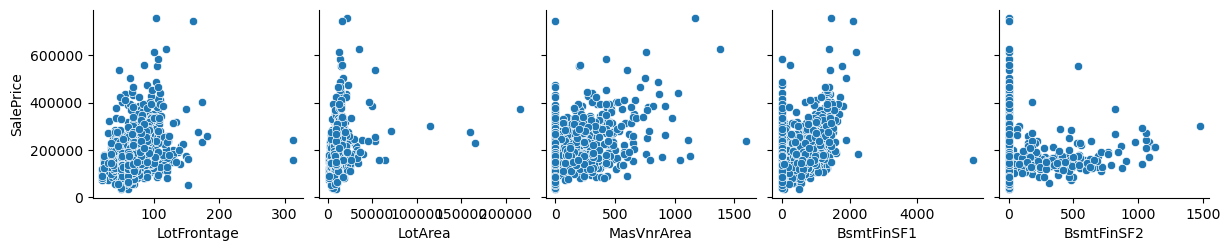

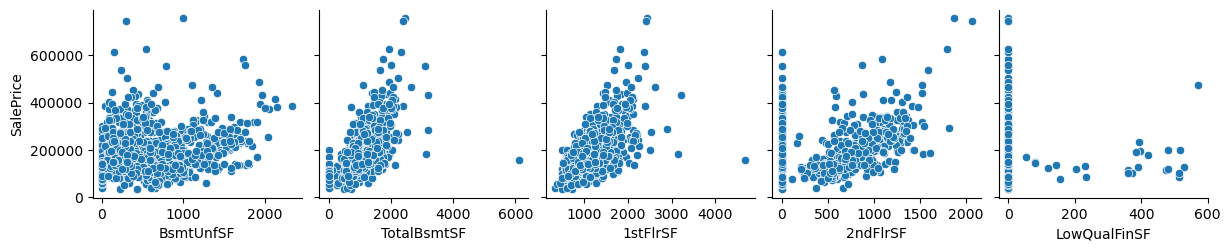

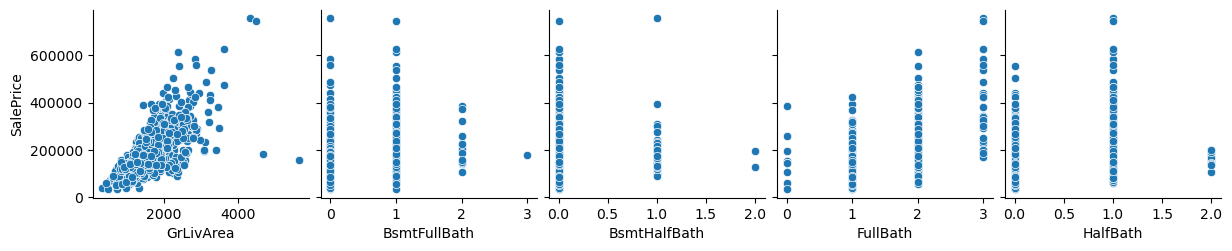

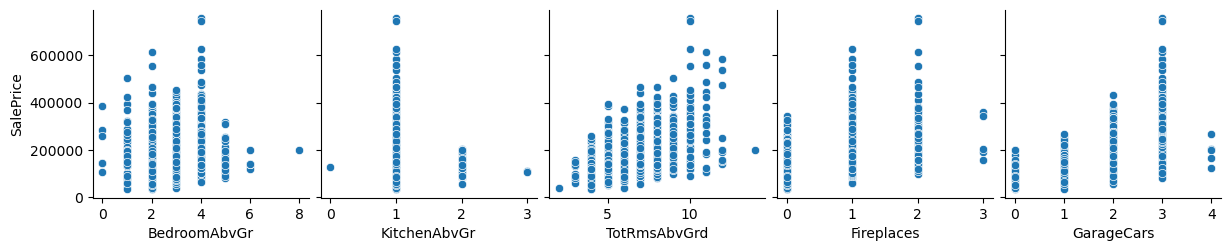

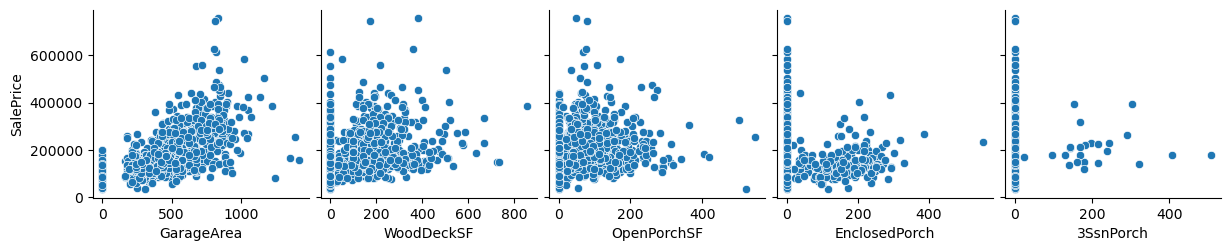

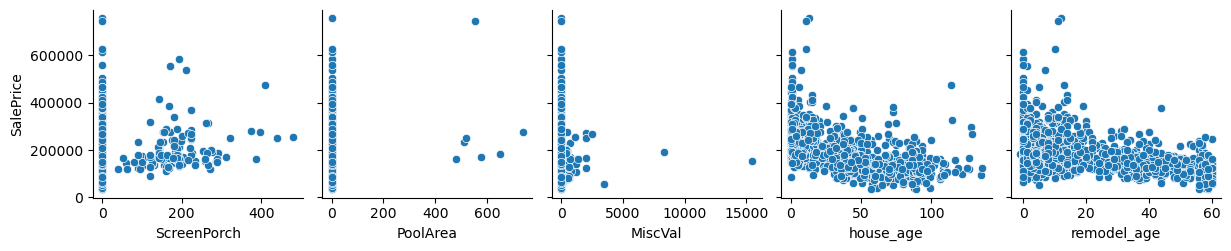

In [157]:
# pairplotting all the numerical columns
n_cols = num_col
n_cols = np.delete(n_cols, np.where(n_cols == 'SalePrice'))
for cols in n_cols.reshape(6,5):
    a_cols = cols
    cols = np.append(cols,'SalePrice')
    sns.pairplot(data=df[cols], x_vars=a_cols , y_vars='SalePrice')
    plt.show()


In [158]:
## plotting graph for Categorical variable


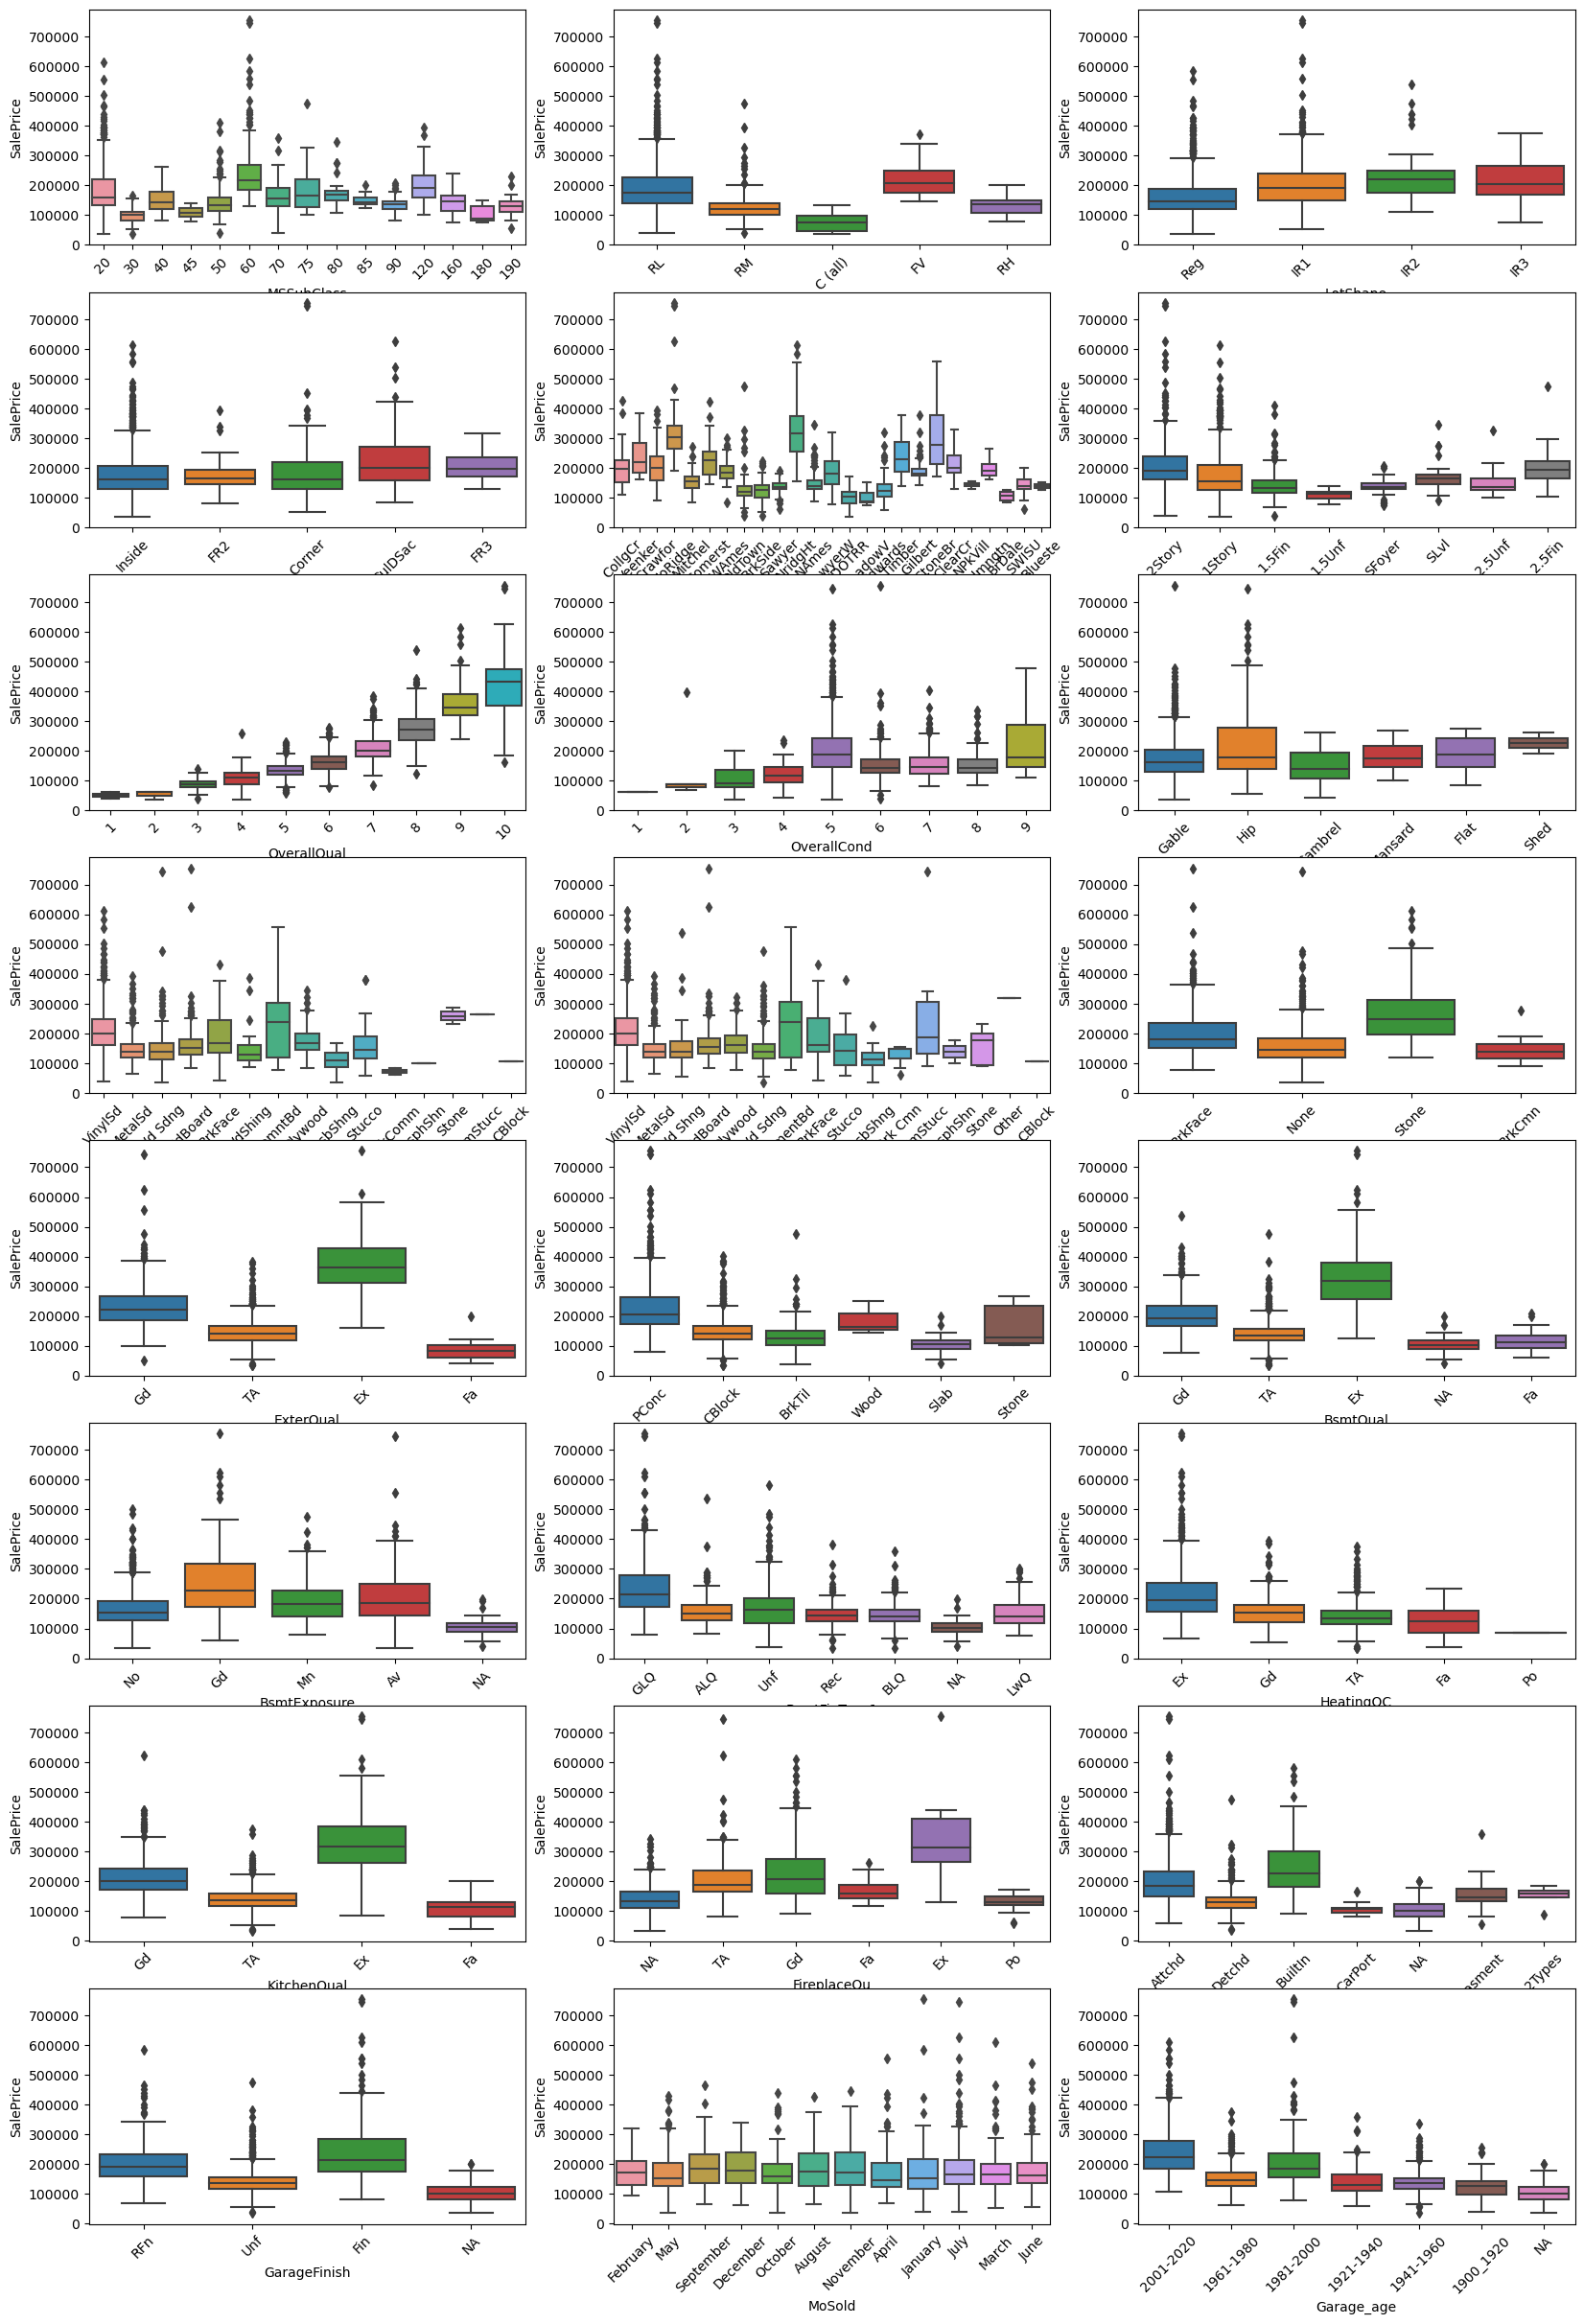

In [159]:
# Function to plot boxplot for categorical variables 
plt.figure(figsize=(20,30))
index=1
for col in cat_col:
    plt.subplot(8,3,index)
    sns.boxplot(x=col,y='SalePrice',data=df)
    plt.xticks(rotation=45)
    index+=1
plt.show()

###### Summary 
- we can infer from the previous percentile and plot outliers are present in both numerical and categorical plot

In [160]:
##### lets try to remove outliers and check the reecords more than 95% percentile
print(len(df[df['SalePrice']>=326100]))
newdf = df[df['SalePrice']<326100]

73


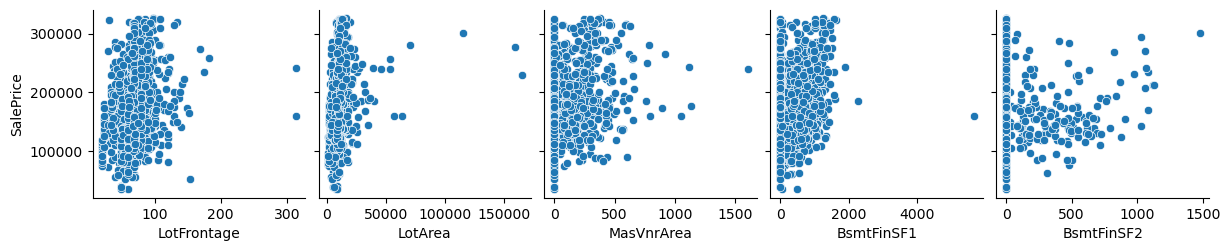

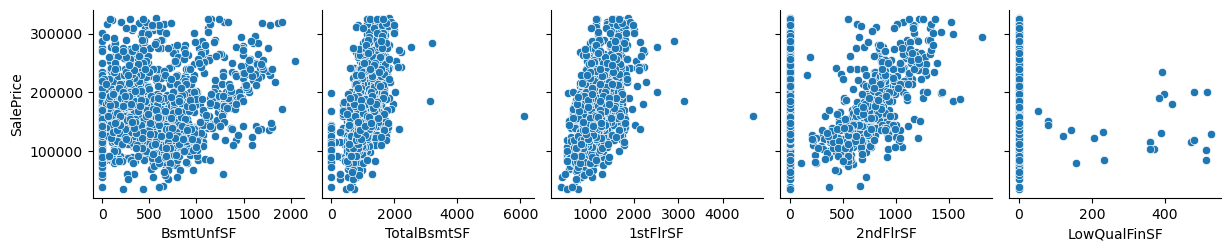

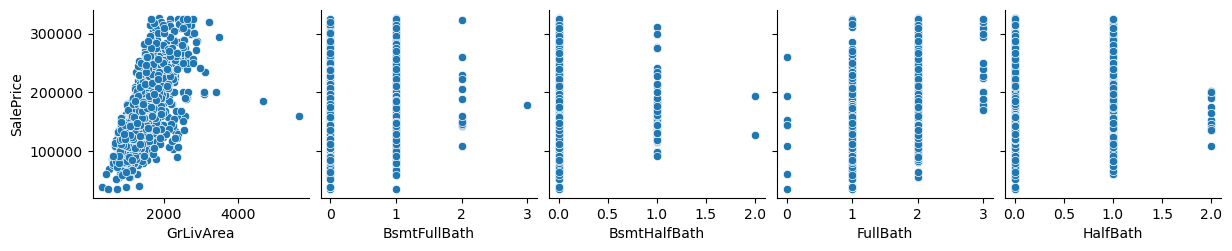

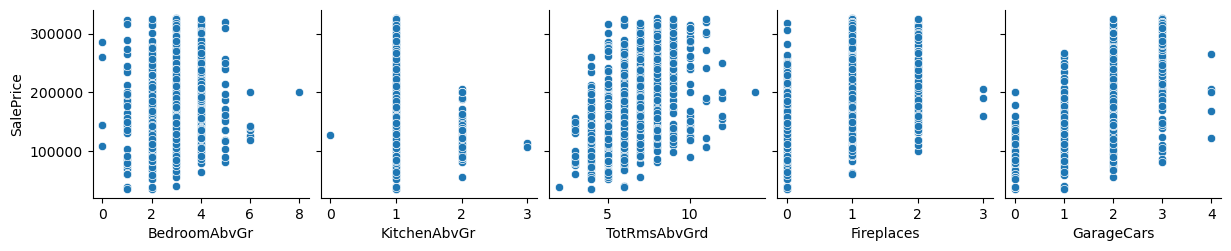

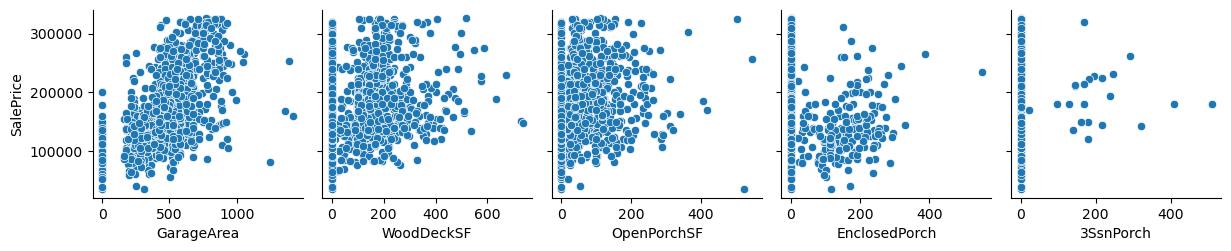

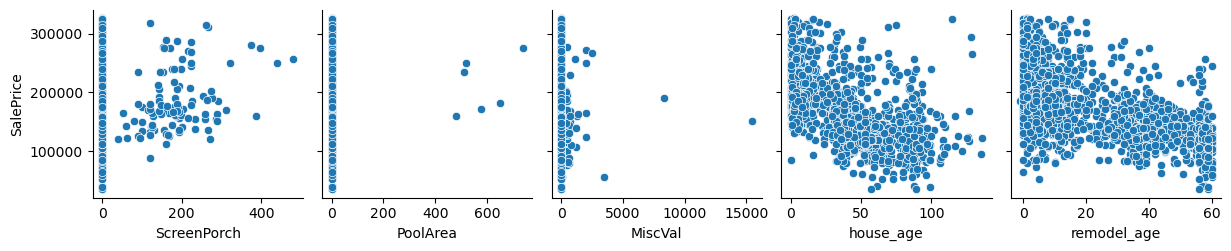

In [161]:
n_cols = num_col
n_cols = np.delete(n_cols, np.where(n_cols == 'SalePrice'))
for cols in n_cols.reshape(6,5):
    a_cols = cols
    cols = np.append(cols,'SalePrice')
    sns.pairplot(data=newdf[cols], x_vars=a_cols , y_vars='SalePrice')
    plt.show()

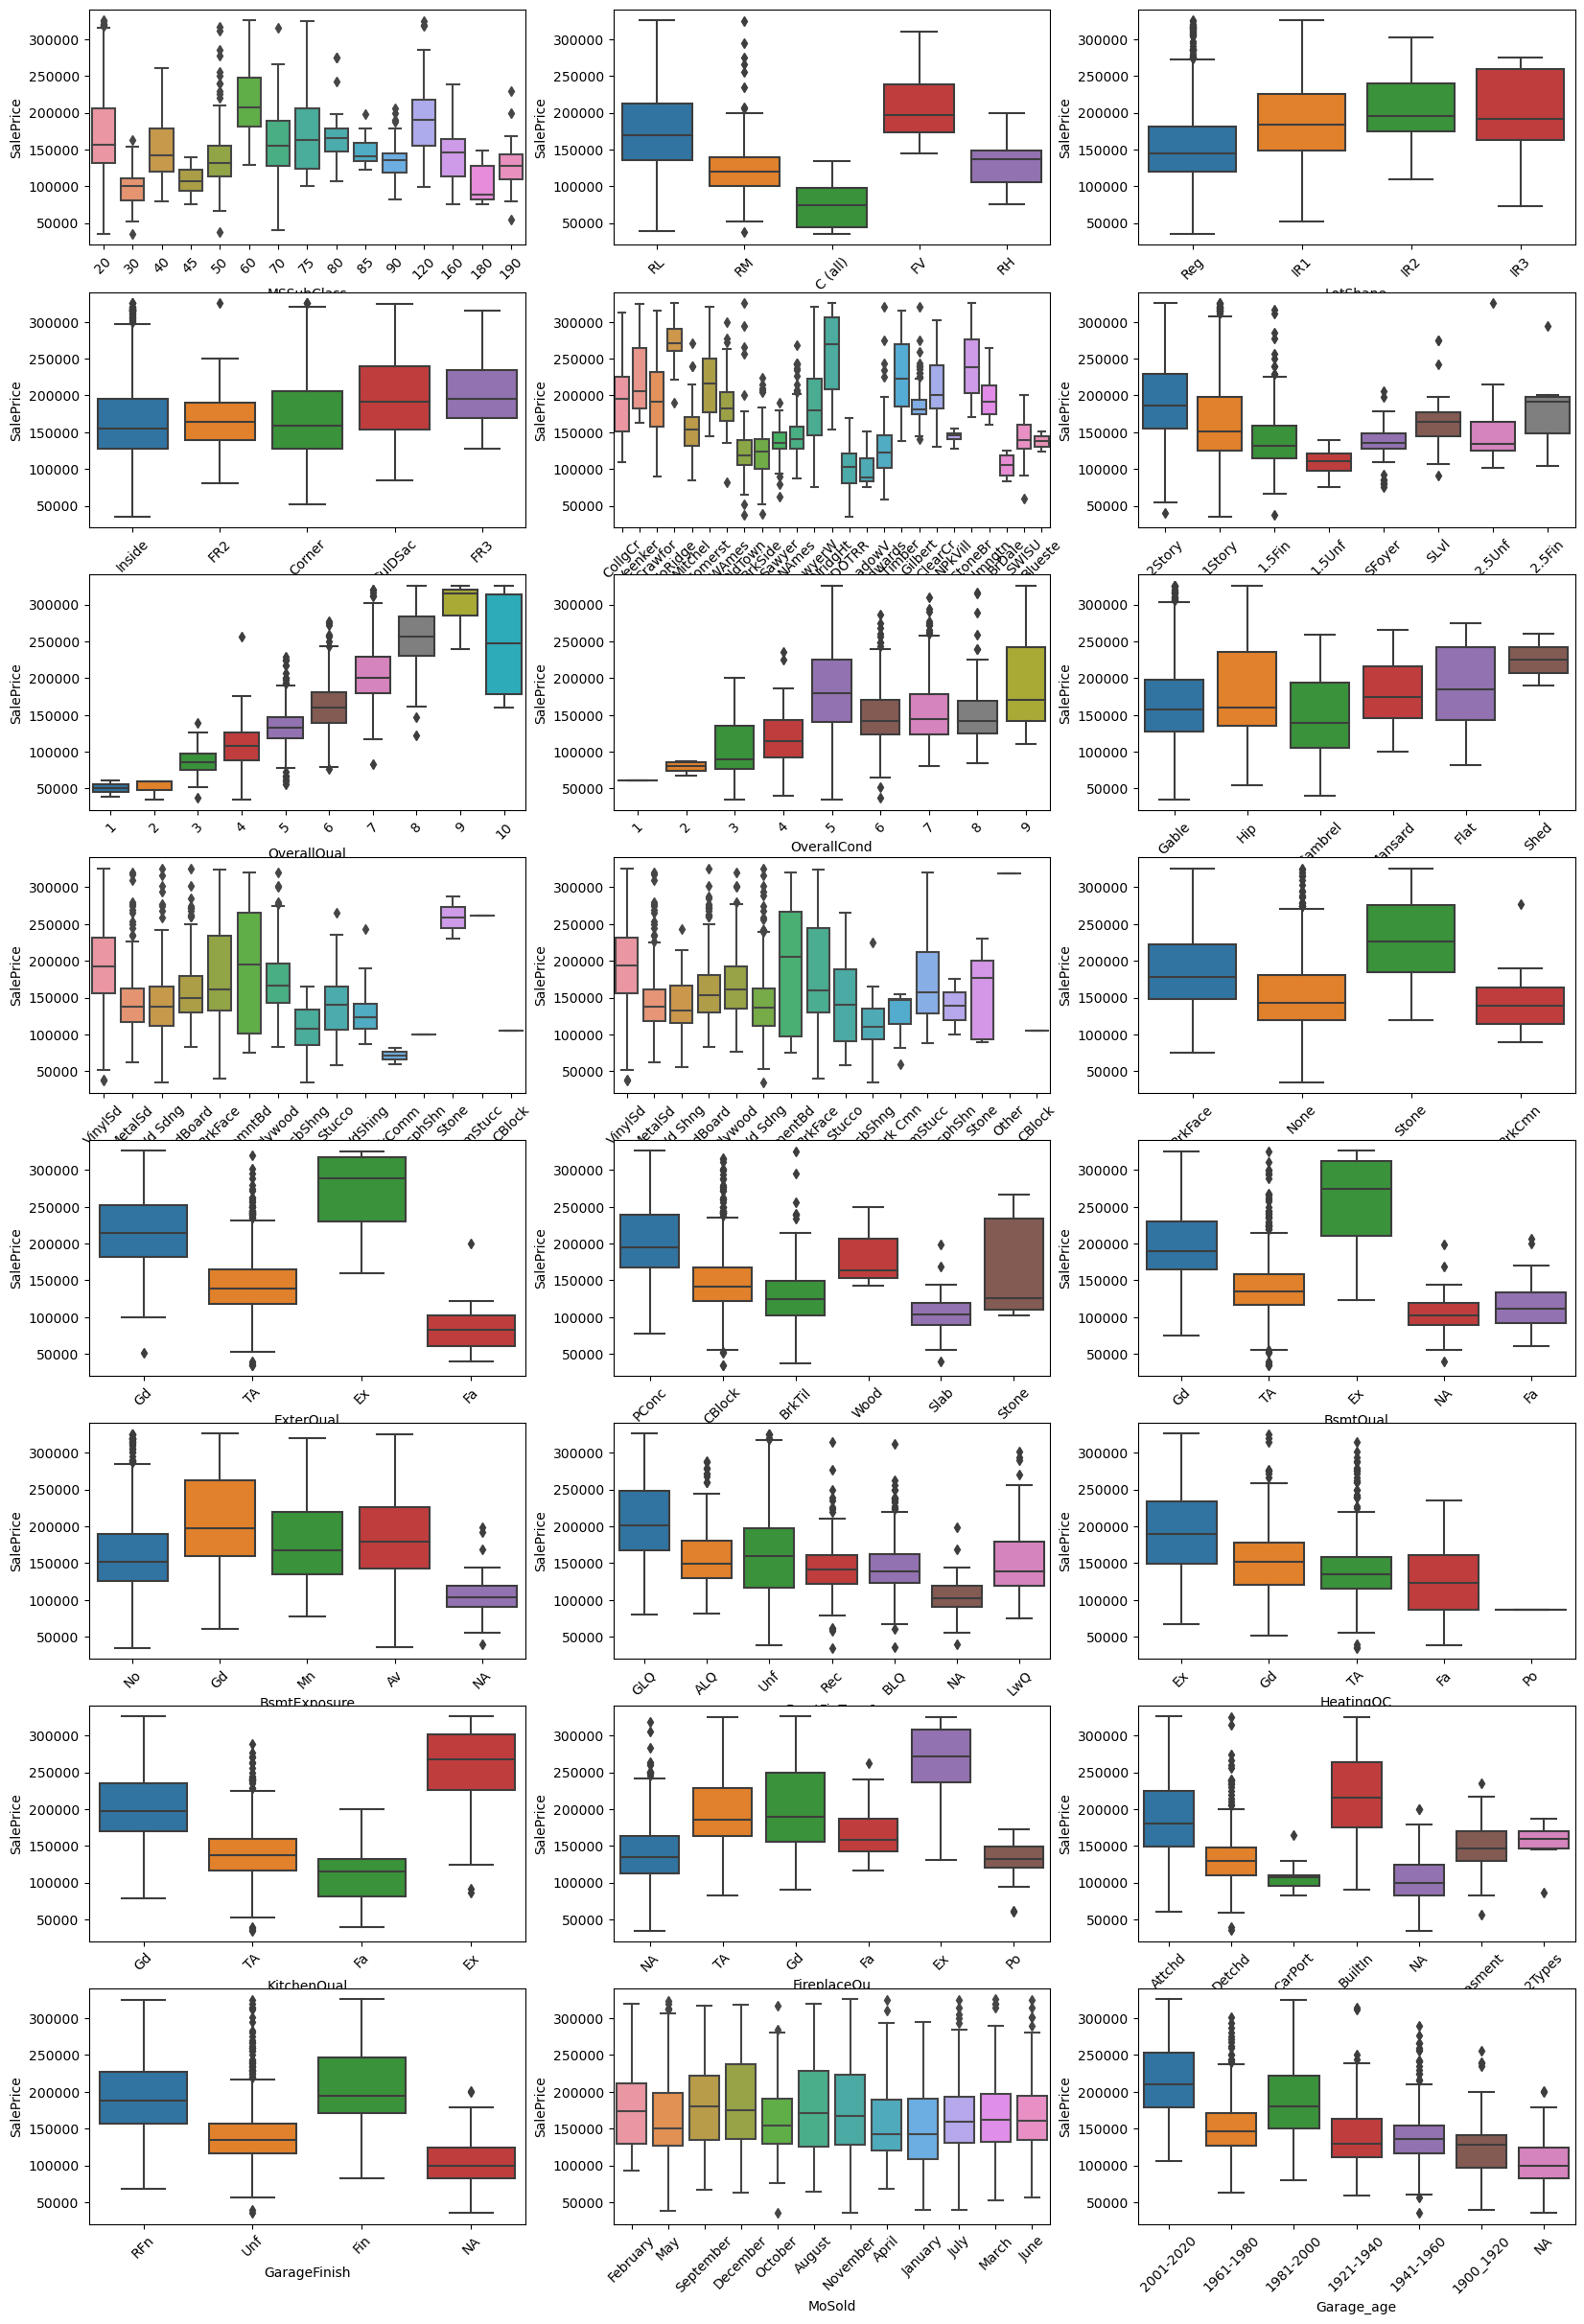

In [162]:
# Function to plot boxplot for categorical variables 
plt.figure(figsize=(20,30))
index=1
for col in cat_col:
    plt.subplot(8,3,index)
    sns.boxplot(x=col,y='SalePrice',data=newdf)
    plt.xticks(rotation=45)
    index+=1
plt.show()

#### Summary 
- There seems to be quite abit reduction in outliers. As data size is small, lets not delete lot of records.


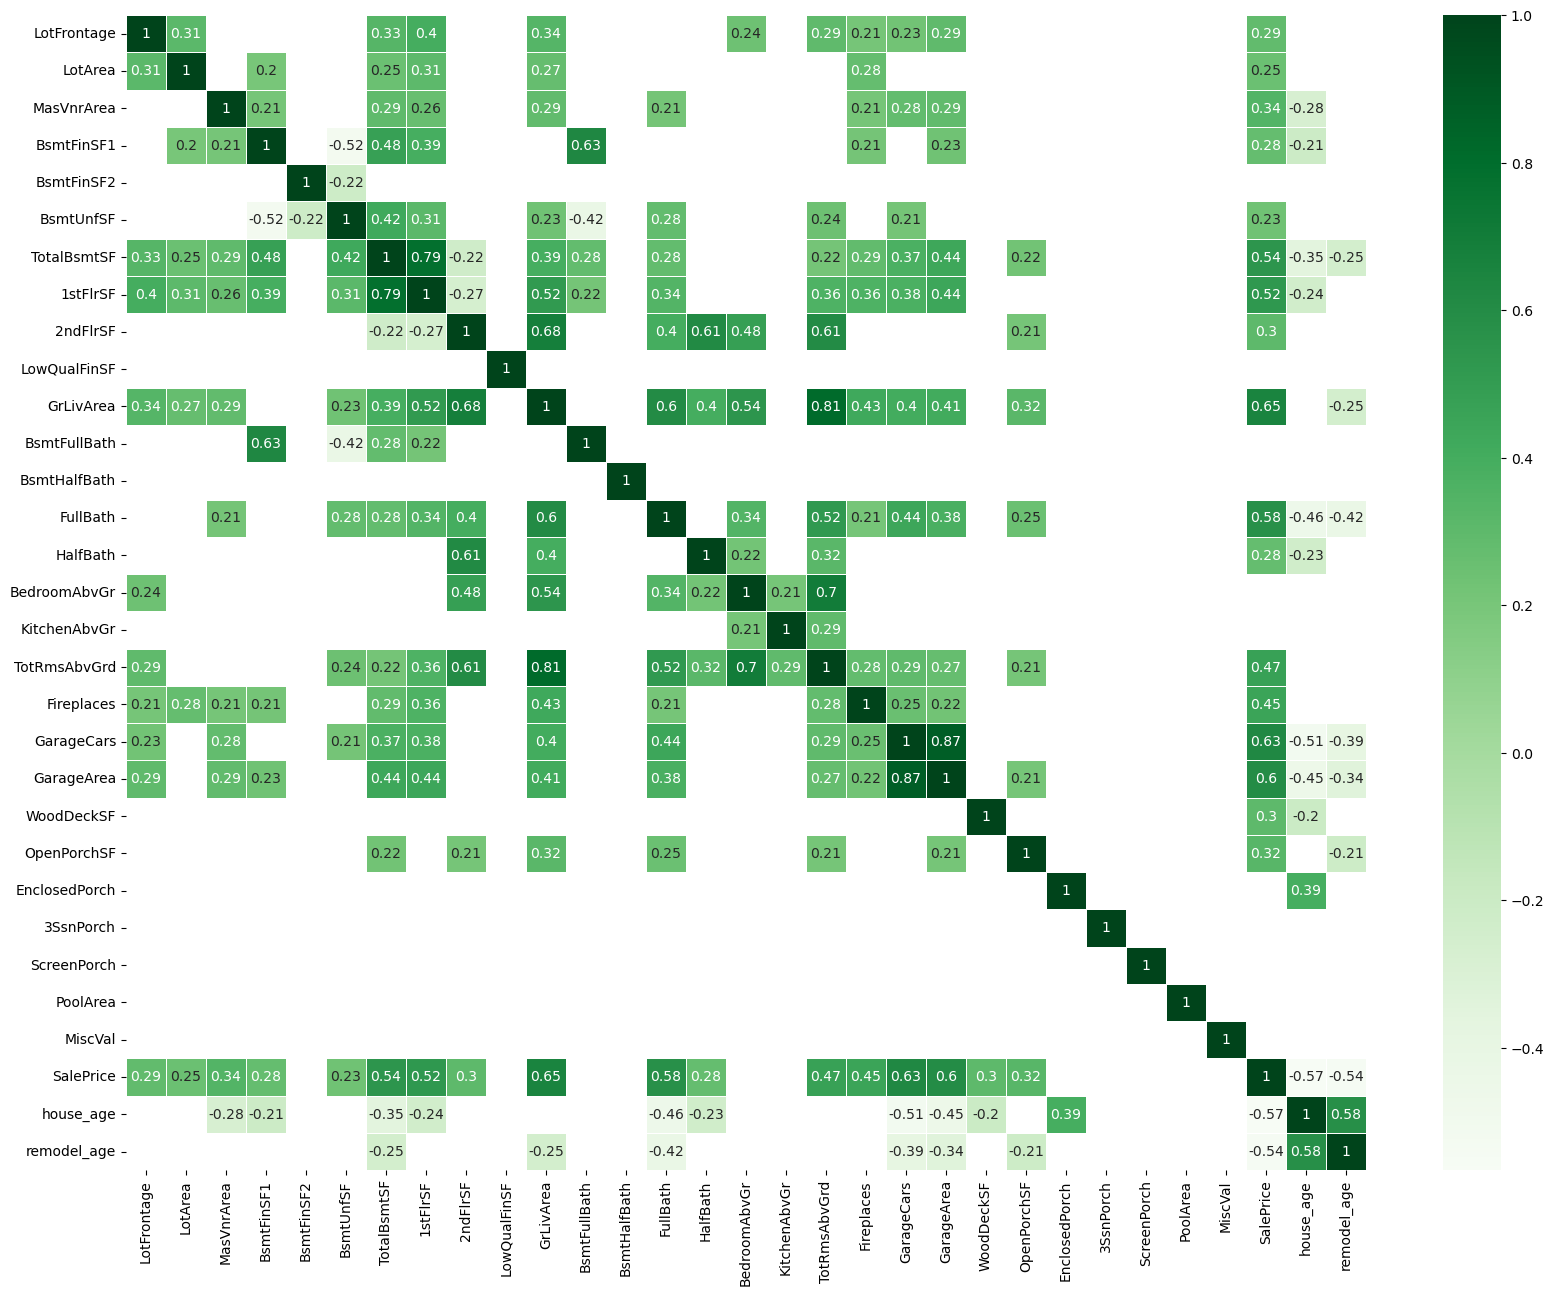

In [163]:
## Correlation bwtween the numerical columns

plt.figure(figsize=(20,15))

corr = newdf[num_col].corr()
sns.heatmap(corr[(corr >= 0.2) | (corr <= -0.2)],
            cmap='Greens',  linewidth=.5 ,
            annot=True);
plt.show()

#### Summary 
- SalesPrice have good correlation withh GarageCars, Garage Area , TotalBsmt 
- Negative with remodel_age , house_age

### Data Preparation


In [164]:
uniq_count_map(cat_col)

{15: ['MSSubClass', 'Exterior1st'],
 5: ['MSZoning', 'LotConfig', 'BsmtQual', 'BsmtExposure', 'HeatingQC'],
 4: ['LotShape', 'MasVnrType', 'ExterQual', 'KitchenQual', 'GarageFinish'],
 25: ['Neighborhood'],
 8: ['HouseStyle'],
 10: ['OverallQual'],
 9: ['OverallCond'],
 6: ['RoofStyle', 'Foundation', 'FireplaceQu'],
 16: ['Exterior2nd'],
 7: ['BsmtFinType1', 'GarageType', 'Garage_age'],
 12: ['MoSold']}

In [165]:
encoder = LabelEncoder()
for col in cat_col:
  newdf[col] = encoder.fit_transform(newdf[col])
  
data = newdf.copy()
newdf[cat_col].head()

/var/folders/_6/fn_76g1n0xvgr1c4pls6_m9c0000gn/T/ipykernel_58706/425814953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf[col] = encoder.fit_transform(newdf[col])


,MSSubClass,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,...,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,MoSold,Garage_age
0,5,3,3,4,5,5,6,4,1,12,...,2,4,2,0,2,3,1,2,3,5
1,0,3,3,2,24,2,5,7,1,8,...,2,1,0,0,3,5,1,2,8,3
2,5,3,0,4,5,5,6,4,1,12,...,2,2,2,0,2,5,1,2,11,5
3,6,3,0,0,6,5,6,4,1,13,...,4,4,0,2,2,2,5,3,3,4
4,5,3,0,2,15,5,7,4,1,12,...,2,0,2,0,2,5,1,2,2,4


#### Summary 
- Using Label Encoder instead of dummy encoding as it reduces number of column and complexity and computation time as well. Dummy Encoder arre better but its better to do label encoding for unique value less than 5. 

In [166]:
data.shape

(1387, 55)

/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


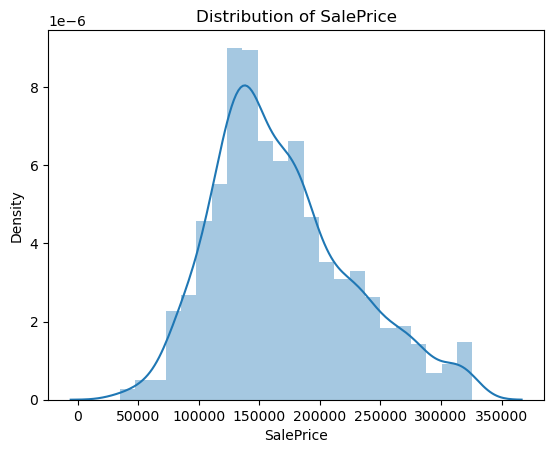

In [167]:
sns.distplot(data['SalePrice'])
plt.title('Distribution of SalePrice') # distribution of SalePrice column
plt.show()

In [168]:
data['SalePrice']= np.log(data["SalePrice"]) # applying log to SalePrice column

/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


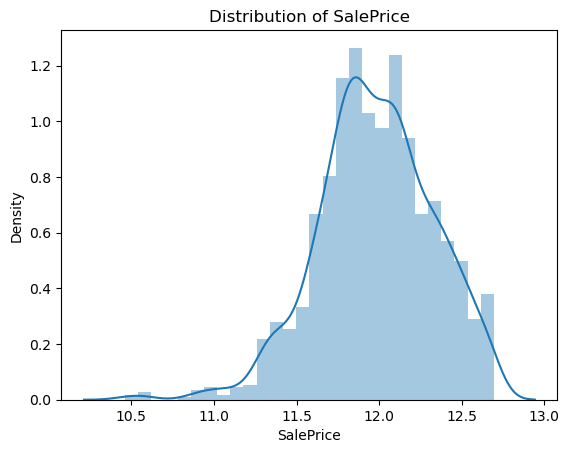

In [169]:
sns.distplot(data['SalePrice'])
plt.title('Distribution of SalePrice') # distribution of SalePrice column
plt.show()

#### Summary
- SalesPrice is Normally distrributed after tranformations

In [170]:
### Train / Test Splitting

In [171]:
### Data Scaling

In [172]:
df_train,df_test=train_test_split(data,train_size=0.7,random_state=0) # Split the data into train and test

In [173]:
scaler = MinMaxScaler()

In [174]:
df_train[num_col]=scaler.fit_transform(df_train[num_col]) 

In [175]:
df_test[num_col]= scaler.transform(df_test[num_col]) 

In [176]:
df_train.describe() 

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,house_age,remodel_age,Garage_age
count,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,...,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,4.116495,3.024742,0.161930,0.055544,1.977320,3.032990,12.045361,2.990722,4.923711,4.589691,...,0.041906,0.006248,0.029691,0.003322,0.004364,5.519588,0.677206,0.281966,0.411408,3.485567
std,4.164799,0.635553,0.068303,0.050721,1.399359,1.614225,6.003955,1.904022,1.255886,1.116855,...,0.114519,0.054630,0.112275,0.052439,0.039133,3.108982,0.154764,0.223033,0.341414,1.428841
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.133562,0.038608,0.000000,2.000000,7.000000,2.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.585087,0.066176,0.098361,3.000000
50%,4.000000,3.000000,0.164384,0.050336,3.000000,4.000000,12.000000,2.000000,5.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.675559,0.264706,0.278689,3.000000
75%,6.000000,3.000000,0.184932,0.062869,3.000000,4.000000,17.000000,5.000000,6.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.781338,0.411765,0.704918,5.000000
max,14.000000,4.000000,1.000000,1.000000,3.000000,4.000000,24.000000,7.000000,9.000000,8.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000


In [177]:
# assigning X_train and y_train
y_train=df_train.pop('SalePrice')
X_train=df_train

In [178]:
# assigning X_test and y_test
y_test=df_test.pop('SalePrice')
X_test=df_test

In [179]:
X_train.shape

(970, 54)

In [180]:
X_test.shape

(417, 54)

In [181]:
#### Linear Regression

In [182]:
# linear regression with RFE - 30 features
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=30)
rfe = rfe.fit(X_train, y_train)

y_train_pred = rfe.predict(X_train)
print("r2 score for train :",r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = rfe.predict(X_test)
print("r2 score for test :",r2_score(y_true=y_test, y_pred=y_test_pred))

r2 score for train : 0.8131753468362488
r2 score for test : 0.8051060053147971


In [183]:
# Generic Method to Calulate VIF 
def calculateVIF(df):
    vif = pd.DataFrame({'feature': df.columns})
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [184]:
# creating RFE DataFrame to easily access the output fo the RFE 
rfe_df = pd.DataFrame({'feature':X_train.columns, 'support':rfe.support_,'ranking':rfe.ranking_})
rfe_df.set_index('ranking',inplace=True)
rfe_df.sort_index(ascending=True)

,feature,support
ranking,,
1,2ndFlrSF,True
1,BsmtFinSF2,True
1,BsmtUnfSF,True
1,TotalBsmtSF,True
1,1stFlrSF,True
1,remodel_age,True
1,WoodDeckSF,True
1,GrLivArea,True
1,BsmtFullBath,True


In [185]:
#Selecting features frrom rfe output
rfe_columns = rfe_df[rfe_df.support].feature
rfe_columns

ranking
1      LotFrontage
1          LotArea
1      OverallQual
1       MasVnrArea
1       BsmtFinSF1
1       BsmtFinSF2
1        BsmtUnfSF
1      TotalBsmtSF
1         1stFlrSF
1         2ndFlrSF
1        GrLivArea
1     BsmtFullBath
1     BsmtHalfBath
1         FullBath
1         HalfBath
1     BedroomAbvGr
1     KitchenAbvGr
1     TotRmsAbvGrd
1       Fireplaces
1       GarageCars
1       GarageArea
1       WoodDeckSF
1      OpenPorchSF
1    EnclosedPorch
1        3SsnPorch
1      ScreenPorch
1         PoolArea
1          MiscVal
1        house_age
1      remodel_age
Name: feature, dtype: object

In [186]:
X_train_rfe = X_train[rfe_columns]
X_test_rfe = X_test[rfe_columns]

In [187]:
calculateVIF(X_train_rfe)

/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
4,BsmtFinSF1,inf
5,BsmtFinSF2,inf
6,BsmtUnfSF,inf
7,TotalBsmtSF,inf
10,GrLivArea,694.72
8,1stFlrSF,365.91
9,2ndFlrSF,134.35
17,TotRmsAbvGrd,43.80
19,GarageCars,32.70
15,BedroomAbvGr,30.50


##### Summary

- R2 Test Score - 80.5%. 
The features selected have multicollinearity , lets use regularization Ridge and Lasso


#### Pre Steps for REgularizations

In [188]:
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20, 50, 100, 200, 500 ]} # hyperparameter

In [189]:
# Line Plot for mkain gpredicted vs acttual comparision
def comparison_plot(y_predicted,y_test):
  fig, ax=plt.subplots(figsize=(18,6))
  sns.lineplot(x=range(len(y_predicted)),y=y_test,label='Actuals',color='orange',ax=ax)
  sns.lineplot(x=range(len(y_predicted)),y=y_predicted,label='Predictions',color='blue',ax=ax)
  ax.set_title('Price: Actuals vs Predictions', fontsize=16)
  ax.set_ylabel('Housing Price Predictions',fontsize=13)
  plt.show()

In [190]:
# RMSE plottin RMSE to identify best alpha value.
def rmse_plot(cv_results):
  alpha = cv_results['param_alpha'].astype('float32')
  # plotting
  plt.plot(alpha, cv_results['mean_train_score'])
  plt.plot(alpha, cv_results['mean_test_score'])
  plt.xlabel('alpha')
  plt.ylabel('Negative Mean Absolute Error')
  plt.xscale('log')
  plt.title("Negative Mean Absolute Error and alpha")
  plt.legend(['train score', 'test score'], loc='upper right')
  plt.show()

In [191]:
# Function Build model Lass / Ridge based on the estimator 
# It also Calculate R2 Score, RMSE and plot RMSE 
def regularization_model(X_train, y_train, X_test, params, k =5, estimator=Ridge()):

  model = GridSearchCV(estimator = estimator, 
                          param_grid = params, 
                          scoring= 'neg_mean_absolute_error', 
                          cv = k, 
                          return_train_score=True,
                          verbose = 1)        
      
  model.fit(X_train, y_train)

  estimator_name = estimator.__class__.__name__
  # Plots the RMSE
  cv_results = pd.DataFrame(model.cv_results_)
  cv_results = cv_results[cv_results['param_alpha']<=500]
  rmse_plot(cv_results)

  #Alpha
  alpha = model.best_params_["alpha"]
  print() # empty line
  print("Optimum alpha for %s is %f" %(estimator_name, alpha))
  final_model = model.best_estimator_

  # Model with best alpha value
  final_model.fit(X_train, y_train)
  y_train_pred = final_model.predict(X_train)
  y_test_pred = final_model.predict(X_test)
 
  # Model Evaluation
  print() # empty line
  print(estimator_name," Regression with ",alpha)
  print("===================================")
  print('R2 score (train) : ',r2_score(y_train,y_train_pred))
  print('R2 score (test) : ',r2_score(y_test,y_test_pred))
  print('RMSE (train) : ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
  print('RMSE (test) : ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

  # computing coef and intercept
  model_parameter = list(final_model.coef_)
  model_parameter.insert(0,final_model.intercept_)
  cols = list(X_train.columns.values)
  cols.insert(0,'constant')
  model_coef_df = pd.DataFrame({'Feature':cols, 'Coef':model_parameter})
  model_coef_df = model_coef_df.sort_values(by='Coef',ascending=False)

  return final_model, y_train_pred, y_test_pred, alpha, model_coef_df

###  RIDGE MODEL

Fitting 5 folds for each of 29 candidates, totalling 145 fits


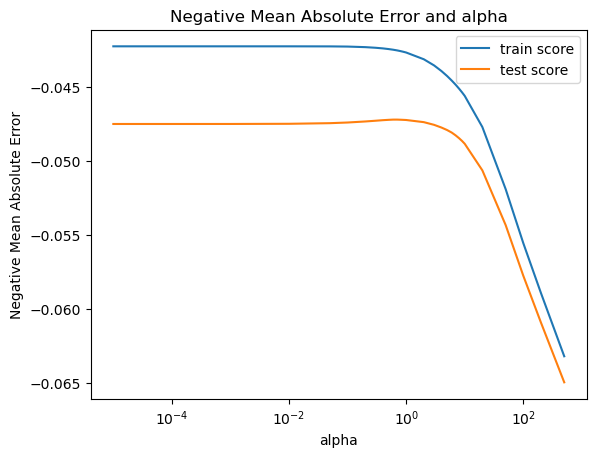


Optimum alpha for Ridge is 0.700000

Ridge  Regression with  0.7
R2 score (train) :  0.841350367643952
R2 score (test) :  0.8420300317600944
RMSE (train) :  0.06161197479775503
RMSE (test) :  0.06422768613393359


In [192]:
ridge_final_model, ridge_y_train, ridge_y_predicted, ridge_alpha, ridge_coef_df = regularization_model(X_train ,y_train,X_test,params,k=5,estimator=Ridge())

In [193]:
ridge_coef_df

,Feature,Coef
0,constant,0.314455
4,LotArea,0.114851
26,1stFlrSF,0.113102
29,GrLivArea,0.111921
42,GarageCars,0.109437
34,BedroomAbvGr,0.108734
37,TotRmsAbvGrd,0.082966
30,BsmtFullBath,0.077496
48,ScreenPorch,0.076626
38,Fireplaces,0.072683


##### Summary 
- Ridge made coefficients Neighborhood ,RoofStyle,LotConfig,MoSold to almost zero. 


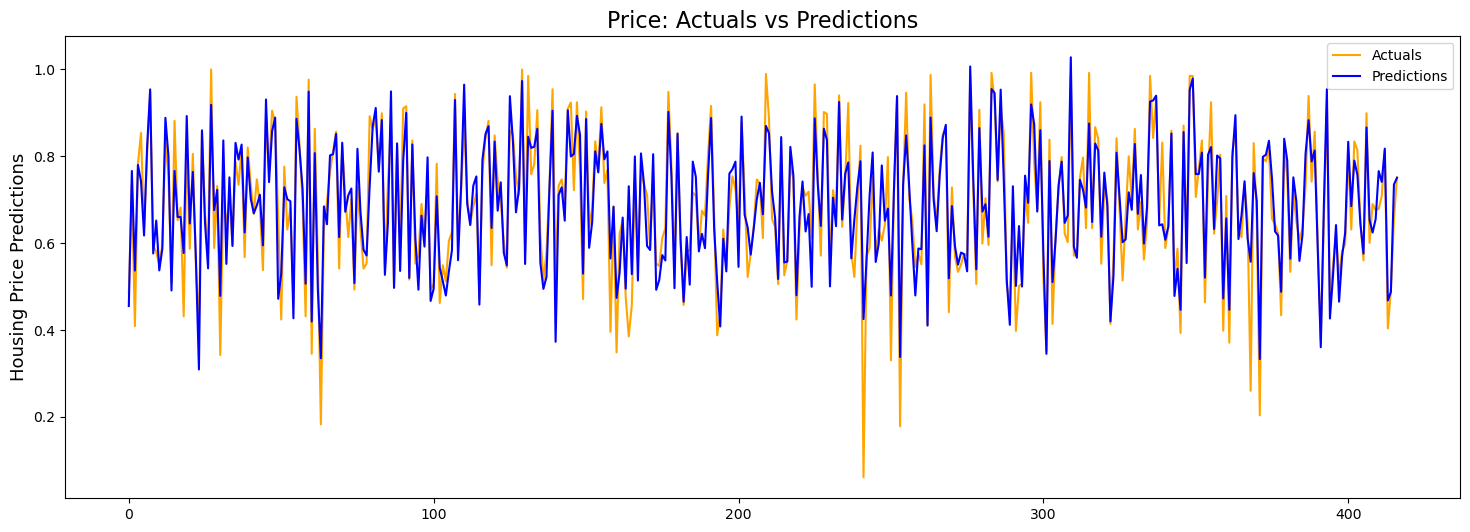

In [194]:
comparison_plot(ridge_y_predicted,y_test)

### LASSO MODEL

Fitting 5 folds for each of 29 candidates, totalling 145 fits


/Users/vineetsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.626e-03, tolerance: 1.841e-03
  model = cd_fast.enet_coordinate_descent(


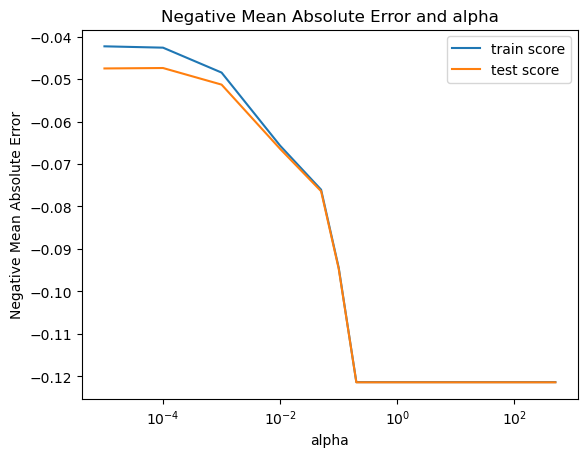


Optimum alpha for Lasso is 0.000100

Lasso  Regression with  0.0001
R2 score (train) :  0.8401700603462888
R2 score (test) :  0.845710862550668
RMSE (train) :  0.06184073772425473
RMSE (test) :  0.06347499664001059


In [195]:
lasso_final_model, lasso_y_train, lasso_y_predicted, lasso_alpha, lasso_coef_df = regularization_model(X_train ,y_train,X_test,params,k=5,estimator=Lasso())

lasso_coef_df

#### Summary 
 - Lasso regression havee made coefficents of Neighborhood ,LowQualFinSF ,2ndFlrSF ,TotalBsmtSF ,BsmtFinSF1 etc  to zero. that reduce the no. of feature and make model less complex.

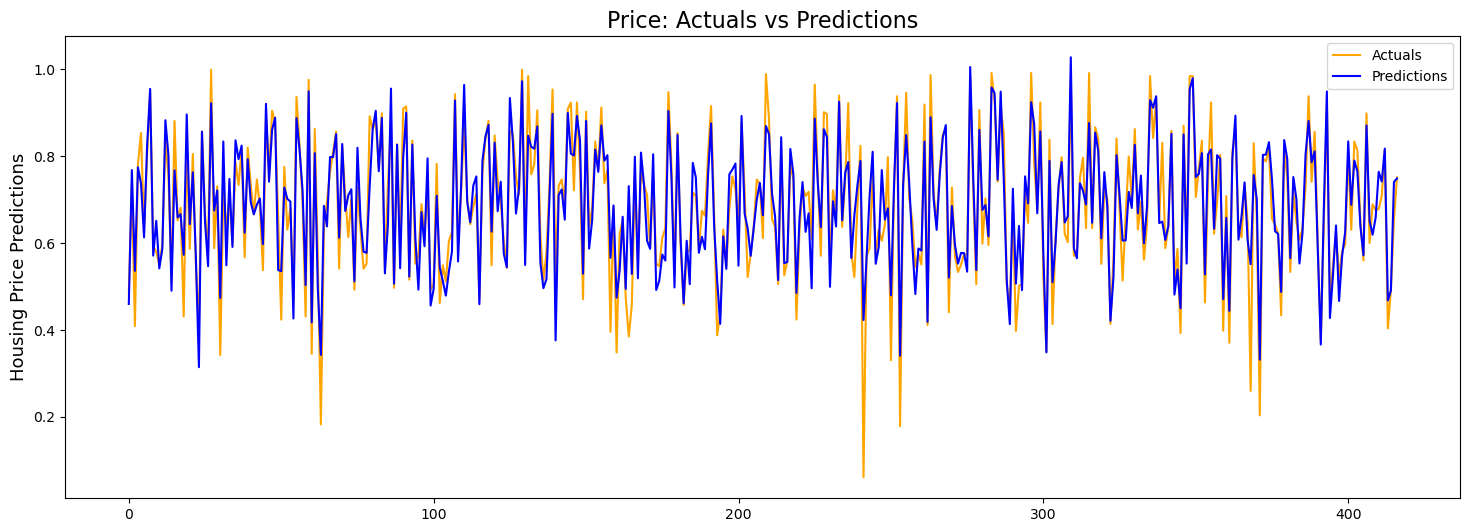

In [196]:
comparison_plot(lasso_y_predicted,y_test)

#### Summary 
- Ridge and Lasso both hhave similar r2 score. alpha value of LAsso is 0.0001 and Ridge is 0.7

### Subjective Questions

In [197]:
# Doubling the Alpha value for Ridge and Lasso
# ridge = 0.7 - after doubling 1.4

### Ridge

Fitting 5 folds for each of 1 candidates, totalling 5 fits


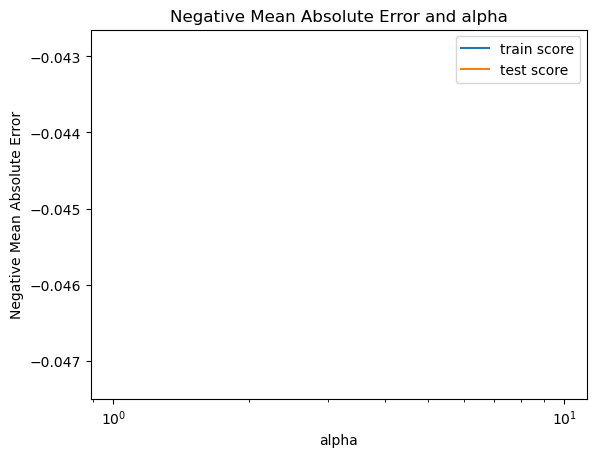


Optimum alpha for Ridge is 1.400000

Ridge  Regression with  1.4
R2 score (train) :  0.8401941252091705
R2 score (test) :  0.8445529281043157
RMSE (train) :  0.061836082010504466
RMSE (test) :  0.06371274019691094


In [198]:
params = {'alpha': [1.4]}

ridge_model_q1, ridge_y_train, ridge_y_predicted, ridge_alpha, ridge_coef_df_q1 = regularization_model(X_train ,y_train,X_test,params,k=5,estimator=Ridge())


In [199]:
ridge_coef_df_q1 = ridge_coef_df_q1.set_index('Feature')
ridge_coef_df_q1.sort_values(by='Coef',ascending=False)

,Coef
Feature,
constant,0.314535
GarageCars,0.105074
BedroomAbvGr,0.101053
GrLivArea,0.097925
1stFlrSF,0.096495
LotArea,0.090787
TotRmsAbvGrd,0.084777
BsmtFullBath,0.075362
Fireplaces,0.073539


#### Lasso 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


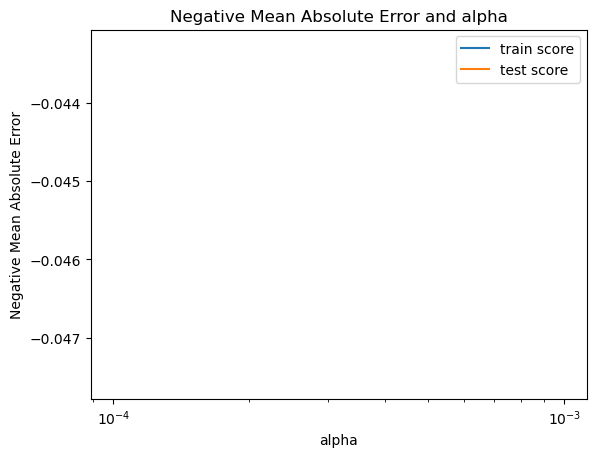


Optimum alpha for Lasso is 0.000200

Lasso  Regression with  0.0002
R2 score (train) :  0.8360877559124604
R2 score (test) :  0.8481937209212927
RMSE (train) :  0.06262551238422064
RMSE (test) :  0.06296219770020679


In [200]:
params = {'alpha': [0.0002]}

lasso_model_q1, lasso_y_train, lasso_y_predicted, lasso_alpha, lasso_coef_df_q1 = regularization_model(X_train ,y_train,X_test,params,k=5,estimator=Lasso())

In [201]:
lasso_coef_df_q1 = lasso_coef_df_q1.set_index('Feature')
lasso_coef_df_q1.sort_values(by='Coef',ascending=False)

,Coef
Feature,
constant,0.310133
GrLivArea,0.253744
GarageCars,0.127235
BedroomAbvGr,0.099155
Fireplaces,0.072772
BsmtFullBath,0.069934
TotRmsAbvGrd,0.066563
ScreenPorch,0.060809
FullBath,0.056597


### Question 2


In [202]:
lasso_coef_df_1 = lasso_coef_df.set_index('Feature')
ridge_coef_df_1 = ridge_coef_df.set_index('Feature')

df1 = pd.merge(lasso_coef_df_1, lasso_coef_df_q1 ,left_index=True, right_index=True)
df2 = pd.merge(ridge_coef_df_1, ridge_coef_df_q1 ,left_index=True, right_index=True)

df3 = pd.merge(df1, df2 ,left_index=True, right_index=True)
df3.rename(columns = {'Coef_x_x' : 'Lasso Alpha(0.0001)' , 'Coef_y_x': 'Lasso Alpha(0.0002)' , 'Coef_x_y': 'Ridge Alpha(0.7)', 'Coef_y_y': 'Ridge Alpha(1.4)'}, inplace = True)

df3.head(10)



,Lasso Alpha(0.0001),Lasso Alpha(0.0002),Ridge Alpha(0.7),Ridge Alpha(1.4)
Feature,,,,
constant,0.314750,0.310133,0.314455,0.314535
GrLivArea,0.283776,0.253744,0.111921,0.097925
GarageCars,0.121063,0.127235,0.109437,0.105074
BedroomAbvGr,0.108154,0.099155,0.108734,0.101053
LotArea,0.104124,0.050978,0.114851,0.090787
BsmtFullBath,0.077525,0.069934,0.077496,0.075362
ScreenPorch,0.071560,0.060809,0.076626,0.071365
Fireplaces,0.071304,0.072772,0.072683,0.073539
TotRmsAbvGrd,0.068700,0.066563,0.082966,0.084777


### Question 3

Fitting 5 folds for each of 29 candidates, totalling 145 fits


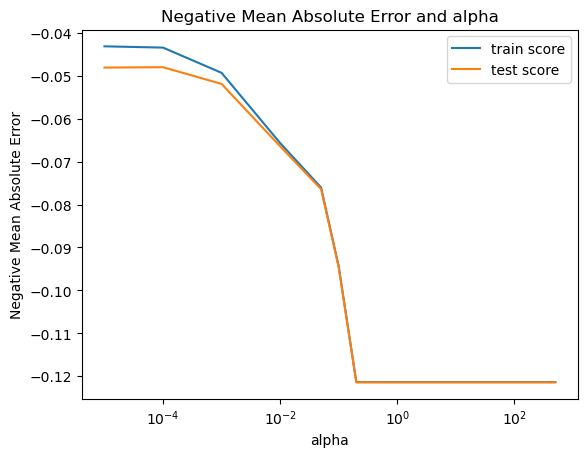


Optimum alpha for Lasso is 0.000100

Lasso  Regression with  0.0001
R2 score (train) :  0.8291831821726903
R2 score (test) :  0.8432810817330634
RMSE (train) :  0.06393091314142148
RMSE (test) :  0.06397285362729677


In [203]:
X_train_q3 = X_train.drop([ 'GrLivArea', 'GarageCars', 'BedroomAbvGr', 'LotArea','BsmtFullBath'], axis=1)
X_test_q3 = X_test.drop(['GrLivArea', 'GarageCars', 'BedroomAbvGr', 'LotArea','BsmtFullBath'], axis=1)


params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20, 50, 100, 200, 500 ]} # hyperparameter

lasso_final_model, lasso_y_train, lasso_y_predicted, lasso_alpha, lasso_coef_df_q3 = regularization_model(X_train_q3 ,y_train,X_test_q3,params,k=5,estimator=Lasso())


In [204]:
lasso_coef_df_q3.head(10)

,Feature,Coef
0,constant,0.356171
25,1stFlrSF,0.222901
33,TotRmsAbvGrd,0.140340
38,GarageArea,0.129379
26,2ndFlrSF,0.094967
23,TotalBsmtSF,0.085550
34,Fireplaces,0.074077
43,ScreenPorch,0.072060
29,FullBath,0.063712
41,EnclosedPorch,0.054133
